# Data quality assessment and remediation

Real-world data is messy. Before analysis, we must handle outliers, extreme values that don't fit the pattern (measurement errors, rare events, or data entry mistakes), and missing values creating gaps in the data (sensor failures, survey non-response, or data collection issues). Ignoring these issues can lead to coding errors, biased statistical estimates, poor model performance, misleading conclusions and, to the extreme, paper retraction. `tangent/ds` provides multiple algorithms for both univariate and multivariate outlier detection, as well as simple and advanced imputation methods.

In [1]:
// Setup DOM for plotting in Jupyter with Deno
import { Window } from 'https://esm.sh/happy-dom@12.10.3';
const window = new Window();
globalThis.document = window.document;
globalThis.HTMLElement = window.HTMLElement;

// import packages
import * as ds from '../../src/index.js';
import * as Plot from '@observablehq/plot';
import _ from 'https://esm.sh/lodash@4.17.21'; // useful for about anything

// data
const penguinsResponse = await fetch(
  'https://cdn.jsdelivr.net/npm/vega-datasets@2/data/penguins.json',
);
const penguinsDataRaw = await penguinsResponse.json();
const penguinsData = penguinsDataRaw // there is a row with a "." instead of null in the Sex field
  .map(row => row.Sex === '.' ? { ...row, Sex: null } : row) // the "." in Sex is missing, change to null
  .map((row, i) => ({ ...row, ID: i })); // we need to give an ID to each observation to keep track of them

console.table(penguinsData.slice(0, 15));

┌───────┬──────────┬─────────────┬──────────────────┬─────────────────┬─────────────────────┬───────────────┬──────────┬────┐
│ (idx) │ Species  │ Island      │ Beak Length (mm) │ Beak Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │ Sex      │ ID │
├───────┼──────────┼─────────────┼──────────────────┼─────────────────┼─────────────────────┼───────────────┼──────────┼────┤
│     0 │ "Adelie" │ "Torgersen" │ 39.1             │ 18.7            │ 181                 │ 3750          │ "MALE"   │ 0  │
│     1 │ "Adelie" │ "Torgersen" │ 39.5             │ 17.4            │ 186                 │ 3800          │ "FEMALE" │ 1  │
│     2 │ "Adelie" │ "Torgersen" │ 40.3             │ 18              │ 195                 │ 3250          │ "FEMALE" │ 2  │
│     3 │ "Adelie" │ "Torgersen" │ null             │ null            │ null                │ null          │ null     │ 3  │
│     4 │ "Adelie" │ "Torgersen" │ 36.7             │ 19.3            │ 193                 │ 3450          │ "FEMALE"

## Outlier detection

The section on outliers comes *before* the section on imputation. We usually remove outliers before imputing, since outliers could draw the imputation to unexpected paths. The outlier detector will filter out missing values, detect numerical fields, apply an optional group by operation, and finally add an field to the table, where `-1` values are detected outliers.

We'll explore three methods.

- isolation Forest, a tree-based anomaly detection (good for high-dimensional data),
- local uutlier factor, density-based detection (finds local anomalies), and
- Mahalanobis distance, a statistical distance accounting for correlations.

### Isolation Forest

Here is how it works.

1. It builds random trees by randomly selecting features and split points
2. Outliers are easier to isolate (require fewer splits)
3. Measures path lengths from root to leaf
4. Shorter paths are anomalies

They are great when you have many features, when outliers are far and when you want a fast, scalable detection. 

In [2]:
const isoForest = new ds.ml.IsolationForest({
  contamination: 0.05,  // expect 5% outliers
  nEstimators: 100,
  maxSamples: 256
});
const penguinsOutliers = isoForest.fit_transform({ data: penguinsData, group: "Species" });
console.table(penguinsOutliers.slice(10, 20));

┌───────┬──────────┬─────────────┬──────────────────┬─────────────────┬─────────────────────┬───────────────┬──────────┬────┬─────────┐
│ (idx) │ Species  │ Island      │ Beak Length (mm) │ Beak Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │ Sex      │ ID │ outlier │
├───────┼──────────┼─────────────┼──────────────────┼─────────────────┼─────────────────────┼───────────────┼──────────┼────┼─────────┤
│     0 │ "Adelie" │ "Torgersen" │ 37.8             │ 17.1            │ 186                 │ 3300          │ null     │ 10 │ 1       │
│     1 │ "Adelie" │ "Torgersen" │ 37.8             │ 17.3            │ 180                 │ 3700          │ null     │ 11 │ 1       │
│     2 │ "Adelie" │ "Torgersen" │ 41.1             │ 17.6            │ 182                 │ 3200          │ "FEMALE" │ 12 │ 1       │
│     3 │ "Adelie" │ "Torgersen" │ 38.6             │ 21.2            │ 191                 │ 3800          │ "MALE"   │ 13 │ 1       │
│     4 │ "Adelie" │ "Torgersen" │ 34.6         

We can check if outliers are on the edges of the data structure using a PCA.

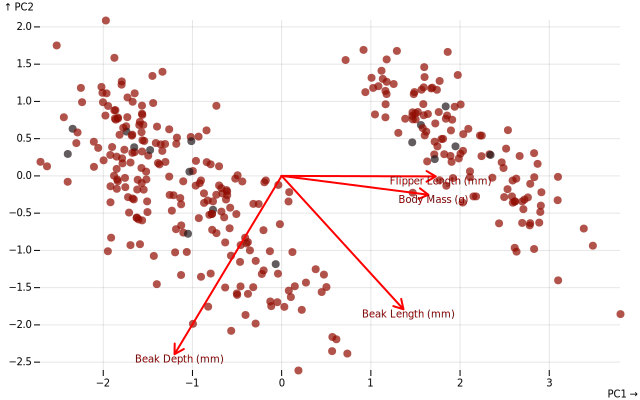

In [3]:
const pcaEstimator = new ds.mva.PCA({
    nComponents: 2,
    scale: true,
    center: true,
    scaling: 1
}).fit({
    data: penguinsData.map(row => _.pick(row, ["Beak Length (mm)", "Beak Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]))
});

ds.plot.ordiplot(pcaEstimator.model, {
  colorBy: penguinsOutliers.map((d) => d.outlier)
}).show(Plot);


The outliers are indeed on the edge.

In [4]:
const penguinsInliers = penguinsOutliers
  .filter(d => d.outlier != -1)
  .map(d => _.omit(d, 'outlier'))

We wont compute outliers for local outlier factor, not with the Mahalanobis distance, we'll just present the methods so that you can change them in the previous code.

### Local outlier factor

LOF

- compares local density of a point to its neighbors,
- if a point is in a low-density region compared to neighbors → outlier,
- uses k-nearest neighbors (default k=20).

It's good when data has clusters of varying density, when you want to find local anomalies (points unusual relative to their neighborhood) and you have moderate-dimensional data.

```
const lof = new ds.ml.LocalOutlierFactor({
  contamination: 0.05,
  n_neighbors: 20
});
```

### Mahalanobis distance

The Mahalanobis distance is a Euclidean distance computed on decorrelated. It takes into account the elliptical shape of data affected by covariance, normally distributed data and provides useful distances from the center of the distributiuon. You will see the Mahalanobis distance everywhere in statistics, and it's useful to detect outliers. In this case, we use pseudoinverse of the covariance for robustness to near-singular covariance matrices, than use chi-squared distribution to set a distance threshold. This method is good for features that are correlated, when you want statistically-principled outlier detection and when data is *approximately* multivariate normal.

```
const mahal = new ds.ml.MahalanobisDistance({
  contamination: 0.05,
  use_chi2: true  // use chi-squared distribution for threshold
});
```

## Missing value imputation

Once outliers are handled, we tackle missing values. Again, many imputers exist.

- The **simple imputer** fills voids with mean/median/mode: it's fast, but ignores the patterns.
- The **KNN imputer** uses k-nearest neighbors to captures local patterns (other ml models could be used, but KNN have shown their reliability).
- The **iterative imputer (MICE)** is a sophisticated multivariate imputation that uses chained equations.

### Simple Imputation

We can replace missing values with the `mean`, the `median`, the `most_frequent` for categorical data or simply a `constant`. As we detected in the statistics section, adelie and chinstrap species are much lighter than gentoo. Imputing missing adelie body mass with the whole mean will return unlikely values.

In [5]:
const simpleImputer = new ds.ml.SimpleImputer({ strategy: 'mean' });
const penguinsSI = simpleImputer.fit_transform({ data: penguinsInliers }); // group: "Species"
console.table(penguinsSI.slice(0, 5))

┌───────┬──────────┬─────────────┬───────────────────┬───────────────────┬─────────────────────┬──────────────────┬──────────┬────┐
│ (idx) │ Species  │ Island      │ Beak Length (mm)  │ Beak Depth (mm)   │ Flipper Length (mm) │ Body Mass (g)    │ Sex      │ ID │
├───────┼──────────┼─────────────┼───────────────────┼───────────────────┼─────────────────────┼──────────────────┼──────────┼────┤
│     0 │ "Adelie" │ "Torgersen" │ 39.1              │ 18.7              │ 181                 │ 3750             │ "MALE"   │ 0  │
│     1 │ "Adelie" │ "Torgersen" │ 39.5              │ 17.4              │ 186                 │ 3800             │ "FEMALE" │ 1  │
│     2 │ "Adelie" │ "Torgersen" │ 40.3              │ 18                │ 195                 │ 3250             │ "FEMALE" │ 2  │
│     3 │ "Adelie" │ "Torgersen" │ 43.74294478527607 │ 17.10674846625767 │ 200.64110429447854  │ 4181.59509202454 │ null     │ 3  │
│     4 │ "Adelie" │ "Torgersen" │ 36.7              │ 19.3              │ 1

### KNN Imputation

For each missing value, find k nearest neighbors using the complete features set. It impute iteratively as weighted average of neighbor values using the Gower distances on the whole feature-set. In this way, it's more advanced than scikit-learn's implementation.

In [6]:
const knnImputer = new ds.ml.KNNImputer({ n_neighbors: 5, weights: 'distance' });
const penguinsKNNI = knnImputer.fit_transform({ data: penguinsInliers });
console.table(penguinsKNNI.slice(0, 5))

┌───────┬──────────┬─────────────┬────────────────────┬────────────────────┬─────────────────────┬────────────────────┬──────────┬────┐
│ (idx) │ Species  │ Island      │ Beak Length (mm)   │ Beak Depth (mm)    │ Flipper Length (mm) │ Body Mass (g)      │ Sex      │ ID │
├───────┼──────────┼─────────────┼────────────────────┼────────────────────┼─────────────────────┼────────────────────┼──────────┼────┤
│     0 │ "Adelie" │ "Torgersen" │ 39.1               │ 18.7               │ 181                 │ 3750               │ "MALE"   │ 0  │
│     1 │ "Adelie" │ "Torgersen" │ 39.5               │ 17.4               │ 186                 │ 3800               │ "FEMALE" │ 1  │
│     2 │ "Adelie" │ "Torgersen" │ 40.3               │ 18                 │ 195                 │ 3250               │ "FEMALE" │ 2  │
│     3 │ "Adelie" │ "Torgersen" │ 38.830000000010344 │ 18.760000000003203 │ 190.8999999998905   │ 3502.5000000049877 │ null     │ 3  │
│     4 │ "Adelie" │ "Torgersen" │ 36.7         

### Iterative Imputation (MICE)

MICE (Multivariate Imputation by Chained Equations) initializes the imputation with mean, then for each numerical feature with missing values, it uses other numerical features to predict it via a regression, then updates imputed values, and repeats until convergence or max iterations. Since MICE uses only numerical fields, `KNNImputer` will almost always provide more accurate values.

In [9]:
const miceImputer = new ds.ml.IterativeImputer({
  initial_strategy: 'mean',
  max_iter: 10,
  tol: 1e-3,
  verbose: true
});
const penguinsInliersGroup = penguinsInliers.map(d => ({...d, group: `${d.Species}_${d.Sex}`}));
const penguinsMICE = miceImputer.fit_transform({ data: penguinsInliersGroup, group: "Species" });
console.table(penguinsMICE.slice(0, 5))

Iteration 1: max change = 0
Converged after 1 iterations
┌───────┬──────────┬─────────────┬───────────────────┬───────────────────┬─────────────────────┬──────────────────┬──────────┬────┬─────────────────┐
│ (idx) │ Species  │ Island      │ Beak Length (mm)  │ Beak Depth (mm)   │ Flipper Length (mm) │ Body Mass (g)    │ Sex      │ ID │ group           │
├───────┼──────────┼─────────────┼───────────────────┼───────────────────┼─────────────────────┼──────────────────┼──────────┼────┼─────────────────┤
│     0 │ "Adelie" │ "Torgersen" │ 39.1              │ 18.7              │ 181                 │ 3750             │ "MALE"   │ 0  │ "Adelie_MALE"   │
│     1 │ "Adelie" │ "Torgersen" │ 39.5              │ 17.4              │ 186                 │ 3800             │ "FEMALE" │ 1  │ "Adelie_FEMALE" │
│     2 │ "Adelie" │ "Torgersen" │ 40.3              │ 18                │ 195                 │ 3250             │ "FEMALE" │ 2  │ "Adelie_FEMALE" │
│     3 │ "Adelie" │ "Torgersen" │ 43.74294

The observation ID==3 has a null species-sex grouping, o it becomes difficult to impute correctly...